<h1>  <center>Question Answering Analysis</center> </h1>
<center>Base on Amazon question/answer data</center> 


Team Members:<br>
18042783  Zoe Wang<br>
17238744  Rebecca Liu<br>
18043158  Yonggang Li<br>




# 1 Introduction
Question Answering is very important for companies to relieve the work load of customer support staff and respond quickly at the same time. Meanwhile, it can also improve the customers experiences as their issues can be solved quickly and accurately.<br>

Our project is to buile a model to answer the customers' questions automatically. Our dataset is Amazon quesiton answer data.(Modeling ambiguity, subjectivity, and diverging viewpoints in opinion question answering systems.http://jmcauley.ucsd.edu/data/amazon/qa/) <br>

Our project is implemtented as the following steps:
* Data EDA and Cleaning
* Naïve approach based on similiarties
* DNN model
  * Vectorize words
  * Q-A Senquence
  * LSTM & Seq2seq learing
  * Implementation with Tensorflow
  * Model traning
  * Prediction (not finished yet)



In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

import warnings
warnings.simplefilter(action='ignore')

In [5]:
sns.set(style="ticks")
sns.set_style("whitegrid")

from pylab import rcParams
rcParams['figure.dpi'] = 100
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['patch.edgecolor'] = 'white'
rcParams['font.family'] = 'StixGeneral'
rcParams['figure.figsize'] = 15,10
rcParams['font.size'] = 16
rcParams['axes.labelsize'] = 'medium'
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
%matplotlib inline

In [6]:
import sys
import json
import nltk
from nltk import clean_html
import random
from nltk.stem.lancaster import LancasterStemmer
stemmer = LancasterStemmer()
from gensim.models import Word2Vec
from gensim import corpora, models, similarities

from textblob import TextBlob, Word
#!pip install gensim
from sklearn.manifold import TSNE
from nltk.corpus import stopwords

#load wordcloud and matplotlib
import matplotlib.pyplot as plt
from scipy.misc import imread
from wordcloud import WordCloud
from wordcloud import WordCloud,ImageColorGenerator

#import multidict as multidict
from PIL import Image

In [7]:
stop_words = nltk.corpus.stopwords.words('english') + [
    '.',    
    ',',
    '#',
    '@',
    '$',
    '%',
    '&',
    '--',
    '\'s',
    '?',
    ')',
    '(',
    '\'',
    '\'\'',
    '\'re',
    '"',
    '-',
    '}',
    '{',
    '!',
    u'—',
    ''
]

# 2 Data Aquisition and EDA

##### Load the Q-A data from JSON file to DataFrame
For each question, there is a measurement "helpful", higher value means it is more helpful. So we only keep the most helpful answers though this may lose some valuable expertise.

In [8]:
# import our intents file
import json
def getdata(path):
    g = open(path,'r')
    for l in g:
        yield eval(l)
intents = list(getdata('/data/QA/QA_Video_Games.json'))
#intents = list(getdata('../Question_Answering/datasets//QA_Video_Games.json'))

In [9]:
qa_df = pd.DataFrame(columns=['asin', 'q_type', 'q_text', 'a_text', 'a_help'])
# loop through each question in our intents
index = 0
for intent in intents:
    asin = intent['asin']
    qObj = {}   
    for question in intent['questions']:
        aObj = {}
        aObj['helpful'] = -1
        for answer in question['answers']:
            #print (answer['helpful'])
            t = answer['helpful']
            if (t[0]+t[1] > aObj['helpful']):
                aObj['helpful'] = t[0]+t[1]
                txt = answer['answerText']
                aObj['a_text'] = answer['answerText']
        qa_df.loc[index] = [asin, question['questionType'], question['questionText'], aObj['a_text'], aObj['helpful']]
        index = index+1
qa_df.head()    

,asin,q_type,q_text,a_text,a_help
0,B0000512IE,open-ended,Can I use these with Window 8/8.1?,"Yes, you will need to go to their website to d...",4
1,B0000512IE,open-ended,Could this be adapted to be used in racing gam...,I googled the question and found many forums o...,0
2,B0000512IE,open-ended,How far are the pedals apart? i.e. the spacing...,4 inches. They are also at an awkward angle wh...,4
3,B0000512IE,open-ended,Is there any adjustment in sensitivity of the ...,I don't think so. My son and husband use this...,2
4,B0000512IE,yes/no,"does anyone use them for Star Citizen, and if ...",Yep. They're a bit small and certainly take so...,2


### Get cloud word plot

Use wordclud to delete stop words and perform word frequency statistics on the file and generate a hash table to determine the importance of words.According to the number of word frequency to generate the image layout in proportion.

In [9]:
excel_file = qa_df['a_text']
excel_file.to_csv('/data/QA/QA_as.txt', sep='\t', index=False)

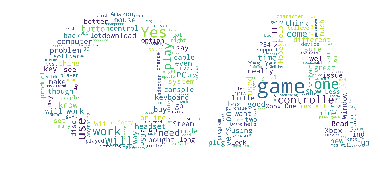

In [10]:
#coding=utf-8
#read a txt file
text = open('/data/QA/QA_as.txt', "r", encoding='utf-8').read()

#load background picture
bg_pic = imread('/data/QA/QA2.png')

#create word cloud
wordcloud = WordCloud(mask=bg_pic, background_color='white', scale=1.5).generate(text)
image_colors = ImageColorGenerator(bg_pic)

#show picture
plt.imshow(wordcloud)
plt.axis('off') 
plt.show()

#save image
wordcloud.to_file('/data/QA/QA_result.jpg')

#### Let check the questions by type

Text(0.5,0,'Question Types')

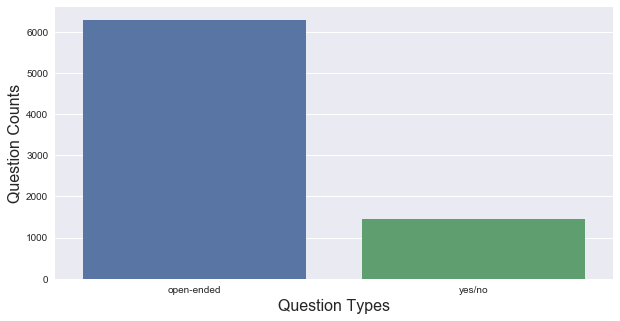

In [10]:
type_df = qa_df.groupby('q_type')
type_labels = type_df.size().index
type_counts = type_df.size().values
sns.set(rc={'figure.figsize':(10, 5)})
sns.barplot(x=type_labels, y=type_counts)
plt.ylabel('Question Counts', fontsize=16)
plt.xlabel('Question Types', fontsize=16)

#### Change question type to 1| 0 and compare two type different quantity 

##### How many questions raised for each products?

In [14]:
grouped_by_asin = qa_df.groupby('asin')
grouped_by_asin = pd.DataFrame({'asin': grouped_by_asin.size().index, 'count': grouped_by_asin.size().values})
grouped_by_asin.sort_values(by='count', ascending=False)
grouped_by_asin['count'].unique()


array([ 4, 10,  5,  3,  9,  7,  8,  6,  1,  2], dtype=int64)

##### There are at most 10 questions and at least 1 questions for all the products, let's check the products numbers for each number of question

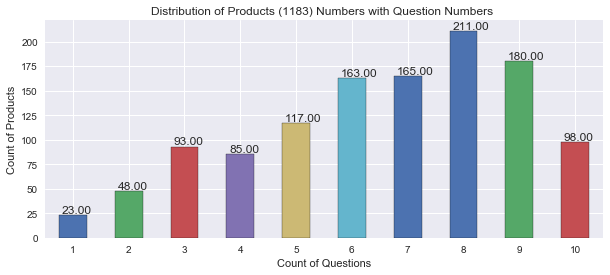

In [15]:
df_asin_count = grouped_by_asin.groupby('count')
df_asin_count = pd.DataFrame({'Questions': df_asin_count.size().index, 'Products': df_asin_count.size().values})
df_asin_count.sort_values(by='Questions')
df_asin_count.head()

ax = df_asin_count.plot(kind='bar', x='Questions', y='Products', rot=0, edgecolor='k', legend=False, figsize=(10,4))
plt.xlabel('Count of Questions'); 
plt.ylabel('Count of Products');
plt.title('Distribution of Products (%d) Numbers with Question Numbers '%(len(grouped_by_asin)))
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.2f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2-0.2, b.y1+2))

##### Show the questions and answers length distribution

The shortest and longest questions are 2 and 2478
The shortest and longest answers are 1 and 7026


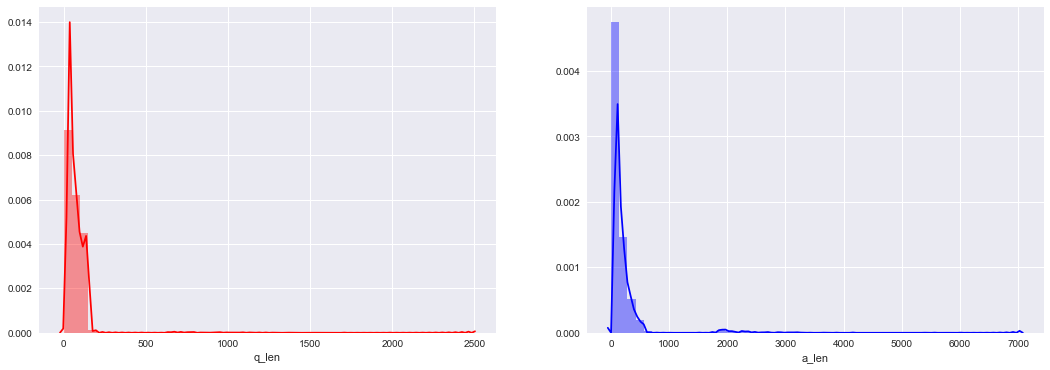

In [14]:
qa_df['q_len'] = qa_df[['q_text']].applymap(len)
qa_df['a_len'] = qa_df[['a_text']].applymap(len)
print('The shortest and longest questions are {} and {}'.format(qa_df['q_len'].min(), qa_df['q_len'].max()))
print('The shortest and longest answers are {} and {}'.format(qa_df['a_len'].min(), qa_df['a_len'].max()))

sns.set(rc={'figure.figsize':(18, 6)})

q_ax = plt.subplot(1, 2, 1)
sns.distplot(qa_df['q_len'], color = 'r',ax=q_ax)
a_ax = plt.subplot(1, 2, 2)
sns.distplot(qa_df['a_len'], color = 'b', ax=a_ax);

plt.show()

From the above chat, we can see that most of the question are shorter than 200 characters and most of the answer are also shorter than 500 character. Let's check how many of them are longer.

In [15]:
long_q = qa_df[qa_df.q_len > 250]
long_a = qa_df[qa_df.a_len > 500]
longest_a = long_a[qa_df.a_len > 2000]
print("{}/{} questions are longer than 200 characters".format(len(long_q), len(qa_df)))
print("{}/{} answers are longer than 500 characters".format(len(long_a), len(qa_df)))
print("{} longest answers, more than 200 characters".format(len(longest_a)))

90/7744 questions are longer than 200 characters
289/7744 answers are longer than 500 characters
116 longest answers, more than 200 characters


For those longer question and answers, we may check their helpful degree. For the most helpful Q-As, it may worth dedicate 
FAQ web pages or just include them in the product user guide or manual. we can also see there are 184 answers longer than 1500 characters.

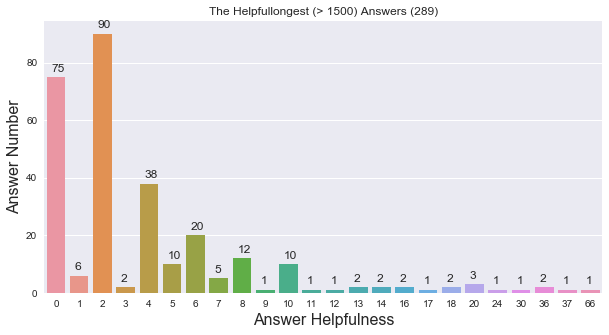

In [18]:
longest_help = long_a.groupby('a_help')
sns.set(rc={'figure.figsize':(10, 5)})
ax = sns.barplot(x=longest_help.size().index, y=longest_help.size().values)
plt.xlabel('Answer Helpfulness', fontsize=16)
plt.ylabel('Answer Number', fontsize=16)
plt.title('The Helpfullongest (> 1500) Answers ({})'.format(len(long_a)))
for p in ax.patches:
    b = p.get_bbox()
    val = "{}".format(int(b.y1 + b.y0))       
    ax.annotate(val, ((b.x0 + b.x1)/2-0.2, b.y1+2))

Since most of them are very helpful, we can give each of them a concise summary for user's quick reference.

The following code are copied from Massey University Course 158755 tutorial.

In [16]:
#source https://github.com/ptwobrussell/Mining-the-Social-Web/blob/master/python_code/blogs_and_nlp__summarize.py
N = 50  # Number of words to consider
CLUSTER_THRESHOLD = 5  # Distance between words to consider
TOP_SENTENCES = 1  # Number of sentences to return for a "top n" summary

def _score_sentences(sentences, important_words):
    scores = []
    sentence_idx = -1

    for s in [nltk.tokenize.word_tokenize(s) for s in sentences]:

        sentence_idx += 1
        word_idx = []

        # For each word in the word list...
        for w in important_words:
            try:
                # Compute an index for where any important words occur in the sentence
                word_idx.append(s.index(w))
            except ValueError: # w not in this particular sentence
                pass

        word_idx.sort()

        # It is possible that some sentences may not contain any important words at all
        if len(word_idx)== 0: continue

        # Using the word index, compute clusters by using a max distance threshold
        # for any two consecutive words

        clusters = []
        cluster = [word_idx[0]]
        i = 1
        while i < len(word_idx):
            if word_idx[i] - word_idx[i - 1] < CLUSTER_THRESHOLD:
                cluster.append(word_idx[i])
            else:
                clusters.append(cluster[:])
                cluster = [word_idx[i]]
            i += 1
        clusters.append(cluster)

        # Score each cluster. The max score for any given cluster is the score 
        # for the sentence

        max_cluster_score = 0
        for c in clusters:
            significant_words_in_cluster = len(c)
            total_words_in_cluster = c[-1] - c[0] + 1
            score = 1.0 * significant_words_in_cluster \
                * significant_words_in_cluster / total_words_in_cluster

            if score > max_cluster_score:
                max_cluster_score = score

        scores.append((sentence_idx, score))

    return scores

def summarize(txt):
    sentences = [s for s in nltk.tokenize.sent_tokenize(txt)]
    normalized_sentences = [s.lower() for s in sentences]

    words = [w.lower() for sentence in normalized_sentences for w in
             nltk.tokenize.word_tokenize(sentence)]

    fdist = nltk.FreqDist(words)

    top_n_words = [w[0] for w in fdist.items() 
            if w[0] not in nltk.corpus.stopwords.words('english')][:N]

    scored_sentences = _score_sentences(normalized_sentences, top_n_words)

    # Summaization Approach 1:
    # Filter out non-significant sentences by using the average score plus a
    # fraction of the std dev as a filter

    avg = np.mean([s[1] for s in scored_sentences])
    std = np.std([s[1] for s in scored_sentences])
    mean_scored = [(sent_idx, score) for (sent_idx, score) in scored_sentences
                   if score > avg + 0.5 * std]

    # Summarization Approach 2:
    # Another approach would be to return only the top N ranked sentences

    top_n_scored = sorted(scored_sentences, key=lambda s: s[1])[-TOP_SENTENCES:]
    top_n_scored = sorted(top_n_scored, key=lambda s: s[0])

    # Decorate the post object with summaries

    return dict(top_n_summary=[sentences[idx] for (idx, score) in top_n_scored],
                mean_scored_summary=[sentences[idx] for (idx, score) in mean_scored])

Let's check an example to see if the summary makes sense.

In [17]:
a_text = long_a['a_text'].values
test_text = a_text[1]
print("The original long answer:\n")
print(test_text)
print("\n")
print("Summary:\n")
summary = summarize(a_text[1])['top_n_summary']
print(summary)

The original long answer:

The Saitek X52 is an awesome value with good performance.  There are some longivity issues but it's still a good setup that offers the most features for the money, great for a first timer.CH Products aren't as flashy and modern looking but tend to last a long time and have excellent sensitivity and accuracy.  The CH software is also very lightweight on resources and offers good programing and the ability to combine multiple devices into one virtual joystick for compatibility with more programs.  CH also has a helpful fan base and third party forums, search for CH Hangar in Google.


Summary:

[u'CH also has a helpful fan base and third party forums, search for CH Hangar in Google.']


# 3 Naive way to answer questions
Intuitively, if a user asks a question that has been answered, we can simply return the answer. Generally, if the user asks a question that has a high similarity with the existing question, we can return the answer back.

##### Tokenize words and get similarity

In [11]:
def sentence_words_mapper(s):
    tmpWords = nltk.word_tokenize(s)
    words = [w.lower() for w in tmpWords if w.lower() not in stop_words]
    return words
    
# quesiton is like ['B0000512IE', 'May I use this in racing games also?']
def find_answer(q):
    k_df = qa_df[qa_df.asin == q[0]]
    k_df['q_text'] = k_df[['q_text']].applymap(sentence_words_mapper)
    
    q_base = k_df.q_text.values.tolist()
    dictionary = corpora.Dictionary(q_base)
    corpus = [dictionary.doc2bow(text) for text in q_base]
    lsi_model = models.LsiModel(corpus, id2word=dictionary)
    q_words = sentence_words_mapper(q[1])
    vec_bow = dictionary.doc2bow(q_words)
    vec_lsi = lsi_model[vec_bow] 
    index = similarities.MatrixSimilarity(lsi_model[corpus]) 
    sims = index[vec_lsi]
    print (sims)
    a_index = -1
    max_prob = 0
    for i in range(len(sims)):
        if (sims[i] > max_prob):
            max_prob = sims[i]
            a_index = i

    return (k_df.loc[a_index].a_text)

In [20]:
print (find_answer(['B0000512IE', 'May I use this in racing games also?']))

[ 4.0254584e-01  8.5392874e-01 -1.7462298e-09  0.0000000e+00
  2.6352811e-01  5.6461431e-09  3.4861490e-01  3.4861493e-01
 -3.0559022e-09]
I googled the question and found many forums of users using both the CH yoke and pedals for racing games. So yes they can be use for racing. - Dave


### Sentiment Analysis with TextBlob

The TextBlob is used for simple subjective and objective analysis of sentences and answers. According to the following figure, the subjectivity score of the question is mainly in the position of 0.4, which makes the question more pertinent.The answer is affected by emotion.

In [14]:
from textblob.sentiments import NaiveBayesAnalyzer, PatternAnalyzer
from textblob import Blobber
from textblob.classifiers import NaiveBayesClassifier
tba = Blobber(analyzer=NaiveBayesAnalyzer())

In [15]:
#Sentiment plot
def checkSemtiment(text):
    pos = []
    for i in text: 
        tmd = TextBlob(i).sentiment.subjectivity
        if tmd > 0:
            pos.append(tmd)
    return pos

#get result
result_sem = checkSemtiment(qa_df['a_text'])
a_subjective = pd.DataFrame(result_sem, columns=['answer_subjective']) 

#get question result
result_sem = checkSemtiment(qa_df['q_text'])
q_subjective = pd.DataFrame(result_sem, columns=['question_subjective']) 

Text(0.5,1,'Sentiment plot for question on subjective analysis')

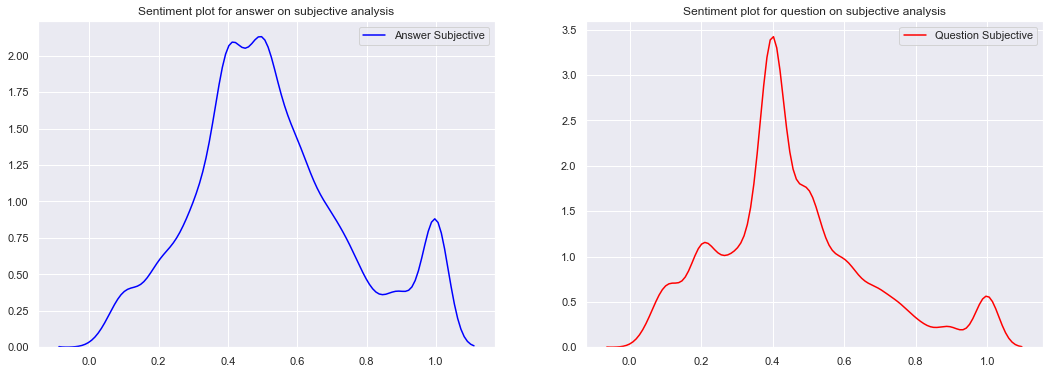

In [16]:
#plot subjective
sns.set(rc={'figure.figsize':(18, 6)})

a_ax = plt.subplot(1, 2, 1)
sns.kdeplot(a_subjective['answer_subjective'],color='blue', label='Answer Subjective', ax=a_ax)
a_ax.set_title('Sentiment plot for answer on subjective analysis')

q_ax = plt.subplot(1, 2, 2)
sns.kdeplot(q_subjective['question_subjective'],color='red', label='Question Subjective', ax=q_ax)
q_ax.set_title('Sentiment plot for question on subjective analysis')

# 4 Neural Network Idea

## 4.1 Word2Vec

Word2vec is a simple two-layer neural networks which can trained to reconstruct linguistic contexts of words. Also we use Word2vec takes a large corpus of text and produces as its input and make a vector space, typically of several hundred dimensions, with each unique word in the corpus being assigned a corresponding vector in the space.

In [21]:
q_a = qa_df[['asin','q_type','q_text','a_text']]
mapping = {"yes/no": 1, "open-ended": 0}
q_a['q_type'] = q_a['q_type'].replace(mapping).astype(np.int)
q_a.head()

,asin,q_type,q_text,a_text
0,B0000512IE,0,Can I use these with Window 8/8.1?,"Yes, you will need to go to their website to d..."
1,B0000512IE,0,Could this be adapted to be used in racing gam...,I googled the question and found many forums o...
2,B0000512IE,0,How far are the pedals apart? i.e. the spacing...,4 inches. They are also at an awkward angle wh...
3,B0000512IE,0,Is there any adjustment in sensitivity of the ...,I don't think so. My son and husband use this...
4,B0000512IE,1,"does anyone use them for Star Citizen, and if ...",Yep. They're a bit small and certainly take so...


In [22]:
# delete number and symbol
import string
def CleanLines(text):
    cleanLine = []
    delEStr = string.punctuation +string.digits
    table = str.maketrans('','',delEStr)
    
    for i in text:       
        #lines = i.translate(identify,delEStr)
        lines = i.translate(table)
        cleanLine.append(lines) 
    return cleanLine
    

In [23]:
t_answer = CleanLines(q_a['a_text'])

In [24]:
#add token in answer question
def getToken(text):
    token_as = []
    for i in text:
        tokens = tokenizer.tokenize(i)
        token_as.append(tokens)
    #return token_as
    return token_as

In [25]:
from nltk.tokenize import RegexpTokenizer
#w means tokens are made of only alphanumeric characters where + indicates that they comprise of one or more of such characters
tokenizer = RegexpTokenizer('\w+')
t_answer = getToken(t_answer)

In [26]:
#delete stop words and make lowercase ?? not lower
def cleanword(text):
    stop_w = []
    for e in text:
        content = [w.lower() for w in e if w.lower() not in stop_words]
        stop_w.append(content)
    return stop_w
t_answer = cleanword(t_answer)

In [28]:
model = Word2Vec(t_answer, sg=1, size=100,  window=5,  min_count=5,  negative=3, sample=0.001, hs=1, workers=5)
#model.save('datasets/application_a.bin')
model.save("datasets/GameWV.bin")
model.wv.save_word2vec_format('datasets/GameWV.txt', binary=False)
model['game'] 

In [31]:
print("Similarity between 'computer' and 'phone'")
model.similarity('computer', 'phone')

Similarity between 'computer' and 'phone'


0.43567425

### Model Virtualization

In [32]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [64]:
#do not run
tsne_plot(model)

### Model parameter adjustment

In [44]:
t_question = CleanLines(q_a['q_text'])
t_question = getToken(t_question)
model_aj = Word2Vec(t_question, sg=1, size=100,  window=5,  min_count=5,  negative=3, sample=0.001, hs=1, workers=5)

In [ ]:
tsne_plot(model_aj)

### Sample for similar word of Game

In [46]:
#Get similartity words of computer
ts = model.wv.similar_by_vector('game')

#Create tokens and labels list
labels_game = []
tokens_game = []
location = model['game'] 

for word in ts:
    tokens_game.append(model[word[0]])
    labels_game.append(word[0])


tokens_game.append(location)
labels_game.append('game')

#Dimention vectors
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens_game) 

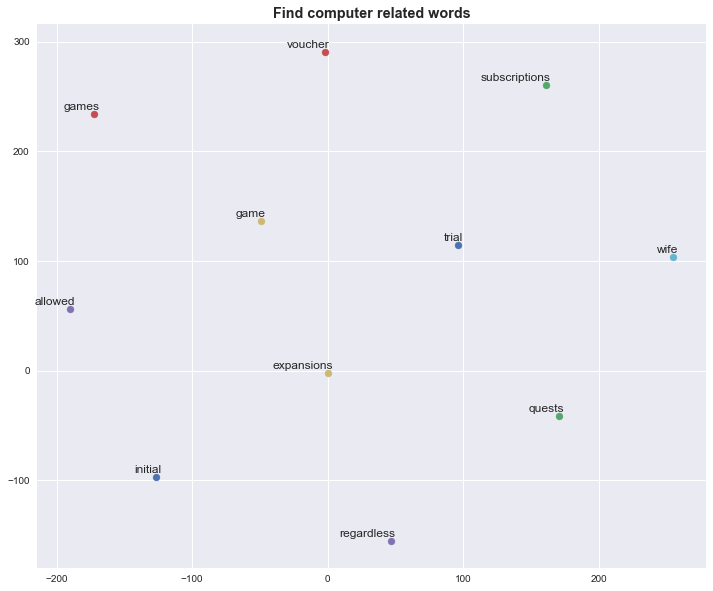

In [49]:
#Create axis for vectprs
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
        
plt.figure(figsize=(12, 10)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels_game[i],
         xy=(x[i], y[i]),
         xytext=(5, 2),
         textcoords='offset points',
         ha='right',
         va='bottom')

plt.title('Find computer related words', fontsize='large', fontweight='bold')    
plt.show()

In [51]:
from mpl_toolkits.mplot3d import Axes3D
tsne = TSNE(n_components=3, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(tokens_game)
labels = labels_game

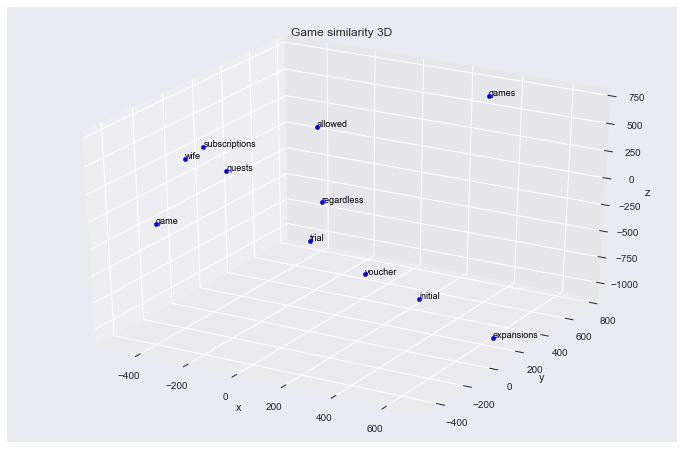

In [55]:
plt.figure(figsize=(12, 8))
ax = plt.subplot(111,projection='3d')

for i in range(len(T)): # plot each point + it's index as text above
    x = T[i,0]
    y = T[i,1]
    z = T[i,2]
    label = labels[i]
    ax.scatter(x, y, z, color='b');
    ax.text(x, y, z, '%s' % (label), size=9, zorder=1, color='k');

ax.set_title('Game similarity 3D');
ax.set_xlabel('x');
ax.set_ylabel('y');
ax.set_zlabel('z');

## 4.2 Q-A Senquence

#### Prepare Data for Training Model

In [12]:
qa_df['q_words'] = qa_df[['q_text']].applymap(sentence_words_mapper)
qa_df['a_words'] = qa_df[['a_text']].applymap(sentence_words_mapper)
def words_len(words):
    return len(words)
qa_df['a_words_len'] = qa_df[['a_words']].applymap(words_len)

tmp = qa_df[qa_df.a_words_len < 100]
q_list = tmp.q_words.values.tolist()
a_list = tmp.a_words.values.tolist()

In [15]:
import string
import unicodedata

def CleanLines(text):
    cleanLine = []
    identify = string.maketrans('', '')
    delEStr = string.punctuation +string.digits
    for i in text:         
        i = i.encode("utf-8")
        lines = i.translate(identify,delEStr)
        cleanLine.append(lines) 
    cleanLine2 = []
    for word in cleanLine:
        if word != '':
            cleanLine2.append(word)
    return cleanLine2

def uni(text):
    uni_text = []
    for i in text:
        i = unicode(i, "utf-8")
        uni_text.append(i)
    return uni_text

def deuni(text):
    deuni_text = []
    for i in text:
        i = i.encode("utf-8")
        deuni_text.append(i)
    return deuni_text

# delete long words
def long_word_filter(words):
    word_list = []
    for i in words:
        if len(i)<15:
            word_list.append(i)
        
    return word_list


# make answer_question pair file

sentences = []
qa_pair = []
for i in range(len(q_list)):
    q = CleanLines(q_list[i])
    a = CleanLines(a_list[i])
    
    # add to our sentence list
    #words.extend(q)
    #words.extend(a)
    sentences.append(q)
    sentences.append(a)
    
    # add to qa_pair
    qa_pair.append((q,a))
        
#words = long_word_filter(words)

### make QA_pair.txt

In [16]:
questions = []
answers = []
for i in range(len(qa_pair)):
    if len(qa_pair[i][0])<150 & len(qa_pair[i][1])<150 :
        question = qa_pair[i][0]
        questions.append(question) 
        answer = qa_pair[i][1]
        answers.append(answer)

In [18]:
fo = open("/data/QA/QA_pair_new.txt", "w")

for i in range(len(questions)):
    for w_q in questions[i]:
        w_q = w_q.lower()
        fo.write( w_q+' ')
        
    fo.write('|')
    
    for w_a in answers[i]:
        w_a = w_a.lower()
        fo.write(w_a+' ')
    
    fo.write('\n')
            
fo.close()

In [19]:
# how many lines(qa_pair) in the file
fo = open("/data/QA/QA_pair_new.txt", "r")
print  len(fo.readlines())

2590


### vectorize the sentences

In [21]:
#load vector
model_w2v = Word2Vec.load('/data/QA/Game_new.bin')
word_vector=model_w2v.wv
#word_vocab = model_w2v.vocabulary
word_vector_dict = word_vector.vocab

def init_seq(input_file):
    """ Read slice words and load sequence
    """
    file_object = open(input_file, 'r')
    vocab_dict = {}
    while True:
        question_seq = []
        answer_seq = []
        line = file_object.readline()
        if line:
            line_pair = line.split('|')
            line_question = line_pair[0]
            line_answer = line_pair[1]
            for word in line_question.split(' '):
                if word_vector_dict.has_key(word):
                    question_seq.append(word_vector[word])
            for word in line_answer.decode('utf-8').split(' '):
                if word_vector_dict.has_key(word):
                    answer_seq.append(word_vector[word])
        else:
            break
        question_seqs.append(question_seq)
        answer_seqs.append(answer_seq)
    file_object.close()

In [22]:
# get the vectorized question & answer 
question_seqs=[]
answer_seqs=[]
init_seq('/data/QA/QA_pair_new.txt')

In [23]:
# how many words in the longest sentece
def get_max_seq_len(seqs):
    seq_lens = []
    for seq in seqs:
        seq_lens.append(len(seq))
        seq_lens.sort(reverse=True)
    return seq_lens[0]

max_q_seq = get_max_seq_len(question_seqs)
max_a_seq = get_max_seq_len(answer_seqs)
print max_q_seq,max_a_seq

17 59


## 4.3 Seq2seq learning model 

In [27]:
import sys
import math
import tflearn
import tensorflow as tf
from tensorflow.python.ops import rnn_cell
from tensorflow.python.ops import rnn
import chardet
import numpy as np
import struct

In [28]:
class MySeq2Seq(object):
    def __init__(self, max_seq_len = 59, word_vec_dim = 100, input_file='/data/QA/QA_pair.txt'):
        self.max_seq_len = max_seq_len
        self.word_vec_dim = word_vec_dim
        self.input_file = input_file
    
    def generate_trainig_data(self):
 
        init_seq(self.input_file)
        xy_data = []
        y_data = []
        for i in range(len(question_seqs)):
        #for i in range(100):
            question_seq = question_seqs[i]
            answer_seq = answer_seqs[i]
            if len(question_seq) < self.max_seq_len and len(answer_seq) < self.max_seq_len:
                #多余的位设为0，与question的reverse合并 * - repeat ；+ - 合并
                sequence_ry = [np.zeros(self.word_vec_dim)] * (self.max_seq_len-len(question_seq)) + list(reversed(question_seq))
                #多余的位设为0， 与answer合并
                sequence_y = answer_seq + [np.zeros(self.word_vec_dim)] * (self.max_seq_len-len(answer_seq))
                #merge
                sequence_xy = sequence_ry + sequence_y
                
                #sequence_xy = question_seq +[np.zeros(self.word_vec_dim)] * (self.max_seq_len-len(question_seq))
                
                sequence_y = [np.ones(self.word_vec_dim)] + sequence_y
                xy_data.append(sequence_xy)
                y_data.append(sequence_y)

               

        return np.array(xy_data), np.array(y_data)
    
    
    def model(self, feed_previous=False):
        # 通过输入的XY生成encoder_inputs和带GO头的decoder_inputs
        input_data = tflearn.input_data(shape=[None, self.max_seq_len*2, self.word_vec_dim], dtype=tf.float32, name = "XY")
        encoder_inputs = tf.slice(input_data, [0, 0, 0], [-1, self.max_seq_len, self.word_vec_dim], name="enc_in")
        decoder_inputs_tmp = tf.slice(input_data, [0, self.max_seq_len, 0], [-1, self.max_seq_len-1, self.word_vec_dim], name="dec_in_tmp")
        go_inputs = tf.ones_like(decoder_inputs_tmp)
        go_inputs = tf.slice(go_inputs, [0, 0, 0], [-1, 1, self.word_vec_dim])
        decoder_inputs = tf.concat([go_inputs, decoder_inputs_tmp], 1,name="dec_in")
        
        
        # encoder
        # 把encoder_inputs交给编码器，返回一个输出(预测序列的第一个值)和一个状态(传给解码器)
        with tf.variable_scope(tf.get_variable_scope(),reuse=tf.AUTO_REUSE):
            (encoder_output_tensor, states) = tflearn.lstm(encoder_inputs, self.word_vec_dim, return_state=True, scope='encoder_lstm')
            encoder_output_sequence = tf.stack([encoder_output_tensor], axis=1)
            

            # decoder
            # 预测过程用前一个时间序的输出作为下一个时间序的输入
            # 先用编码器的最后一个输出作为第一个输入
            if feed_previous:
                first_dec_input = go_inputs
            else:
                first_dec_input = tf.slice(decoder_inputs, [0, 0, 0], [-1, 1, self.word_vec_dim])
            decoder_output_tensor = tflearn.lstm(first_dec_input, self.word_vec_dim, initial_state=states, return_seq=False, reuse=False, scope='decoder_lstm')
            decoder_output_sequence_single = tf.stack([decoder_output_tensor], axis=1)
            decoder_output_sequence_list = [decoder_output_tensor]
            # 再用解码器的输出作为下一个时序的输入
            for i in range(self.max_seq_len-1):
                if feed_previous:
                    next_dec_input = decoder_output_sequence_single
                else:
                    next_dec_input = tf.slice(decoder_inputs, [0, i+1, 0], [-1, 1, self.word_vec_dim])
                decoder_output_tensor = tflearn.lstm(next_dec_input, self.word_vec_dim, return_seq=False, reuse=True, scope='decoder_lstm')
                decoder_output_sequence_single = tf.stack([decoder_output_tensor], axis=1)
                decoder_output_sequence_list.append(decoder_output_tensor)
                
            
            decoder_output_sequence = tf.stack(decoder_output_sequence_list, axis=1)
           
            real_output_sequence = tf.concat([encoder_output_sequence, decoder_output_sequence],1)
             
            net = tflearn.regression(real_output_sequence, optimizer='sgd', learning_rate=0.1, loss='mean_square', name="targetY")            
            net = tflearn.fully_connected(net, 1, activation='softmax')

            print "begin create DNN model"          
            model = tflearn.DNN(net, tensorboard_verbose=0, checkpoint_path=None)
            print "create DNN model finish"
            return model
    
    def train(self):
        trainXY, trainY = self.generate_trainig_data()
        model = self.model(feed_previous=False)
        model.fit(trainXY, trainY, n_epoch=1, snapshot_epoch=False, batch_size=1)
        model.save('/data/QA/model_tensorflow')
        return model
    
    def load(self):
        model = self.model(feed_previous=True,reuse=True)
        model.load('/data/QA/model_tensorflow')
        return model

## 4.4 Training the model

In [29]:
my_seq2seq = MySeq2Seq( max_seq_len = 59, word_vec_dim = 100, input_file='/data/QA/QA_pair_new.txt')

In [32]:
tf.reset_default_graph()
model = my_seq2seq.train()

Training Step: 7764  | total loss: 0.01329 | time: 272.936s
| SGD | epoch: 001 | loss: 0.01329 -- iter: 7764/7764
INFO:tensorflow:/data/QA/model_tensorflow is not in all_model_checkpoint_paths. Manually adding it.


## 4.5 Prediction
We have not done this. What we need to do in the future is:
* Get an input question from the customer
* Transfer the question to a Tensorflow input
* Use our model to predict the target which is a list of vectors
* Translate the list of vectors to a list of words
* Generate a human friendly answer from the list of words



# 5 Limitations
* NLP is a big area, involve lots of knowledge and technologies, we do not have enough time to do all the things.
* Fast evolving libraries ，tensorflow, gensim, we met a lot of problems caused by the diffirences between versions.
* We have limitations of computing resource to train complex RNN model.
* For the prediction part, we have the idea of how to do the most of them. But generating human friendly answers from a list of words is another complex topic.
* Some of the tags of the QA data, like, question type, helpful, are not considered in the our model. There is a article talked about this, which is about Mixtures of Experts.(http://cseweb.ucsd.edu/~jmcauley/pdfs/www16b.pdf)




# 6 References
* https://medium.com/@adityathakker/introduction-to-word2vec-how-it-works-453ab2fb0721
* http://scikit-learn.org/stable/auto_examples/manifold/plot_t_sne_perplexity.html
* https://radimrehurek.com/gensim/similarities/docsim.html
* http://seaborn.pydata.org/generated/seaborn.barplot.html  
* Understanding LSTM Networks(http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* https://github.com/farizrahman4u/seq2seq 
* Sequence to Sequence Learning with Neural Networks (http://cn.arxiv.org/pdf/1409.3215.pdf)
